In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import numpy as np 
import torchvision

In [2]:
batch_size = 64

!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST
from torchvision import transforms

train_set = MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=True)


test_set = MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=False)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2, drop_last=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2, drop_last=True)

--2021-11-08 20:56:42--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-11-08 20:56:43--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [ <=>                ]  33.20M  1.88MB/s    in 17s     

2021-11-08 20:57:00 (1.99 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [3]:
class Discriminator(nn.Module):
    def __init__(self, image_nc):
        super(Discriminator, self).__init__()
        model = [
            nn.Conv2d(image_nc, 8, kernel_size=4, stride=1, padding=0, bias=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 1, 2),
            nn.Sigmoid()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        output = self.model(x).squeeze()
        return output

In [4]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type='reflect', norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [5]:
class Generator(nn.Module):
    def __init__(self,
                 gen_input_nc,
                 image_nc,
                 ):
        super(Generator, self).__init__()

        encoder_lis = [
            nn.Conv2d(gen_input_nc, 8, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
        ]

        bottle_neck_lis = [ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),]

        decoder_lis = [
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, image_nc, kernel_size=6, stride=1, padding=0, bias=False),
            nn.Tanh(),
        ]
        self.linear = nn.Linear(32*5*5+10, 32*5*5)
        self.encoder = nn.Sequential(*encoder_lis)
        self.bottle_neck = nn.Sequential(*bottle_neck_lis)
        self.decoder = nn.Sequential(*decoder_lis)

    def forward(self, x, gen_labels):
        x = self.encoder(x)
        one_hot = F.one_hot(gen_labels, 10)
        x = self.linear(torch.cat((x.view(-1, 32*5*5), one_hot), 1)).view(-1, 32, 5,5)
        noise = torch.randn(*x.shape).cuda()
        x = self.bottle_neck(x+noise)
        x = self.decoder(x)
        return x

In [6]:
class ModelA(nn.Module):
    def __init__(self):
        super(ModelA, self).__init__()
        model = [
            nn.Conv2d(1, 64, kernel_size=5, stride=5, padding=0, bias=True),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=5, stride=5, padding=0, bias=True), nn.ReLU(),
            nn.Dropout(0.25),
            nn.Flatten(start_dim=1),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0,5),
            nn.Linear(128,10)
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        output = self.model(x)
        return output

In [7]:
classifier = ModelA().cuda()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()
for epoch in range(10):
  for i, (x,y) in enumerate(train_loader):
    x, y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    train_loss = loss(classifier(x), y)
    train_loss.backward()
    optimizer.step()
    if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Classifier_loss: {}'.format(epoch+1, 10, i+1, len(train_loader), train_loss.item()))

Epoch [1/10], Step [1/937], Classifier_loss: 2.2906105518341064
Epoch [1/10], Step [101/937], Classifier_loss: 0.4727855622768402
Epoch [1/10], Step [201/937], Classifier_loss: 0.4438789486885071
Epoch [1/10], Step [301/937], Classifier_loss: 0.42064234614372253
Epoch [1/10], Step [401/937], Classifier_loss: 0.1294296234846115
Epoch [1/10], Step [501/937], Classifier_loss: 0.17731717228889465
Epoch [1/10], Step [601/937], Classifier_loss: 0.26464590430259705
Epoch [1/10], Step [701/937], Classifier_loss: 0.14155814051628113
Epoch [1/10], Step [801/937], Classifier_loss: 0.3612595498561859
Epoch [1/10], Step [901/937], Classifier_loss: 0.2875309884548187
Epoch [2/10], Step [1/937], Classifier_loss: 0.24410031735897064
Epoch [2/10], Step [101/937], Classifier_loss: 0.19427239894866943
Epoch [2/10], Step [201/937], Classifier_loss: 0.21081216633319855
Epoch [2/10], Step [301/937], Classifier_loss: 0.3115581274032593
Epoch [2/10], Step [401/937], Classifier_loss: 0.13880065083503723
Epoch 

In [8]:
def accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy: %s %%' % (100 * correct / total))

In [9]:
accuracy(classifier)

Accuracy: 97.43589743589743 %


In [29]:
epochs = 50
lr = 1e-3
G = Generator(1,1).cuda()
D = Discriminator(1).cuda()
Goptimizer = torch.optim.Adam(G.parameters(), lr=lr)
Doptimizer = torch.optim.Adam(D.parameters(), lr=lr)
CELoss = nn.CrossEntropyLoss()
for epoch in range(epochs):
  for i,(x,y) in enumerate(train_loader):
    x,y = x.cuda(), y.cuda()

    labels = torch.randint(0,10, (x.shape[0],)).cuda()
    perturbations = G(x, labels)
    adv_images = perturbations + x
    adv_images = torch.clamp(adv_images, 0, 1)

    Doptimizer.zero_grad()
    pred_real = D(x)
    loss_D_real = loss_D_real = F.mse_loss(pred_real, torch.ones_like(pred_real).cuda())
    loss_D_real.backward()

    pred_fake = D(adv_images.detach())
    loss_D_fake = F.mse_loss(pred_fake, torch.zeros_like(pred_fake).cuda())
    loss_D_fake.backward()
    Doptimizer.step()

    Goptimizer.zero_grad()
    pred_fake = D(adv_images)
    loss_G_fake = F.mse_loss(pred_fake, torch.ones_like(pred_fake).cuda())
    loss_G_fake.backward(retain_graph=True)

    # calculate perturbation norm
    C = 0.1
    loss_perturb = torch.mean(torch.norm(perturbations.view(perturbations.shape[0], -1), 2, dim=1))
    # loss_perturb = torch.max(loss_perturb - C, torch.zeros(1, device=self.device))

    # cal adv loss
    logits_model = classifier(adv_images)
    probs_model = F.softmax(logits_model, dim=1)
    onehot_labels = torch.eye(10).cuda()[labels]

    # C&W loss function
    real = torch.sum(onehot_labels * probs_model, dim=1)
    other, _ = torch.max((1 - onehot_labels) * probs_model - onehot_labels * 10000, dim=1)
    zeros = torch.zeros_like(other)
    loss_adv = torch.max(real - other, zeros)
    loss_adv = torch.sum(loss_adv)

    # maximize cross_entropy loss
    # loss_adv = -F.mse_loss(logits_model, onehot_labels)
    #loss_adv = F.cross_entropy(logits_model, labels)

    adv_lambda = 10
    pert_lambda = 1
    loss_G = adv_lambda * loss_adv + pert_lambda * loss_perturb
    loss_G.backward()
    Goptimizer.step()

    if i%100==0:
      print('Epoch [{}/{}], Step [{}/{}], LossG: {}, LossD: {}, foolLoss: {}, lossperturb: {}'.format(epoch+1, epochs, i+1, len(train_loader), loss_G.item(), (loss_D_fake + loss_D_real).item(), loss_adv.item(), loss_perturb.item()))

Epoch [1/50], Step [1/937], LossG: 46.148040771484375, LossD: 0.5156847238540649, foolLoss: 3.032554864883423, lossperturb: 15.822492599487305
Epoch [1/50], Step [101/937], LossG: 15.829667091369629, LossD: 0.011110607534646988, foolLoss: 0.07739847898483276, lossperturb: 15.055682182312012
Epoch [1/50], Step [201/937], LossG: 14.652613639831543, LossD: 0.0030314126051962376, foolLoss: 0.08206015825271606, lossperturb: 13.832012176513672
Epoch [1/50], Step [301/937], LossG: 12.778658866882324, LossD: 0.0017289792886003852, foolLoss: 0.03154100477695465, lossperturb: 12.463249206542969
Epoch [1/50], Step [401/937], LossG: 13.107786178588867, LossD: 0.0010360298911109567, foolLoss: 0.07923845946788788, lossperturb: 12.315402030944824
Epoch [1/50], Step [501/937], LossG: 14.311502456665039, LossD: 0.0007134987972676754, foolLoss: 0.30177193880081177, lossperturb: 11.293783187866211
Epoch [1/50], Step [601/937], LossG: 11.457818984985352, LossD: 0.0003655283653642982, foolLoss: 0.126375287

In [30]:
def adv_accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          gen_labels = torch.randint(0,10, (x.shape[0],)).cuda()
          perturbation = torch.clamp(G(images, gen_labels), -0.3, 0.3)
          outputs = net(torch.clamp(images + perturbation, 0, 1))
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Adversarial accuracy: %s %%' % (100 * correct / total))

In [31]:
adv_accuracy(classifier),
torch.save(G, "generator-mnisht-random-50.pt")

Adversarial accuracy: 48.908253205128204 %


In [32]:
def label(target, batch_size):
  return (target * torch.ones(batch_size)).cuda().long()

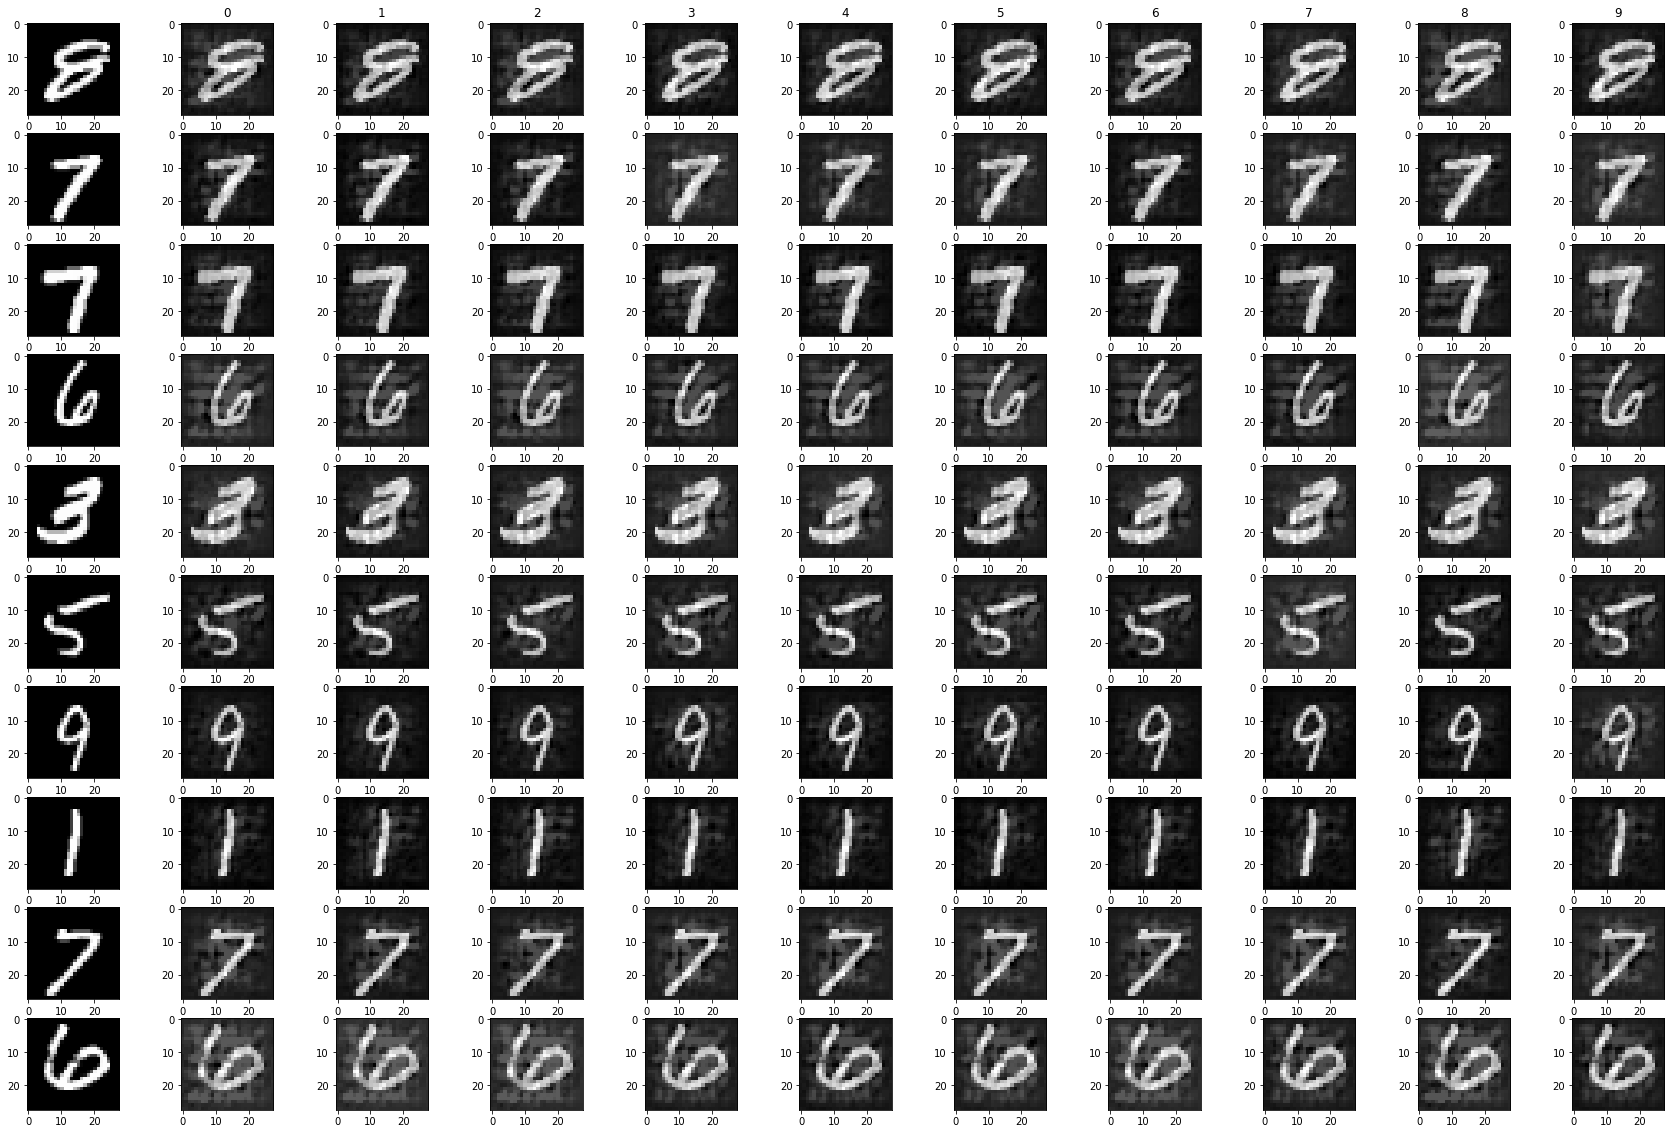

In [33]:
for x,y in train_loader:
  x, y = x.cuda(), y.cuda()
  x = x[:10]
  y = y[:10]
  fig, axs = plt.subplots(x.shape[0], 11)
  fig.set_figheight(20)
  fig.set_figwidth(30)
  for j in range(x.shape[0]):
    axs[j, 0].imshow(x[j].detach().cpu().numpy().transpose(1,2,0).squeeze(2), cmap='gray')
  for i in range(10):
    axs[0,i+1].title.set_text(str(i))
    labels = label(i, x.shape[0])
    perturbations = torch.clamp(G(x, labels), -0.3, 0.3)
    adv_images = x + perturbations 
    for j in range(x.shape[0]):
      axs[j, i+1].imshow(adv_images[j].detach().cpu().numpy().transpose(1,2,0).squeeze(2), cmap='gray')
  break

plt.show()

In [ ]:
for x,y in test_loader:
  gen_labels = torch.randint(0,10, (x.shape[0],)).cuda()
  x,y = x.cuda(), y.cuda()
  base_predictions = F.softmax(classifier(x), 1)

  perturbations = torch.clamp(G(x, gen_labels), -0.3, 0.3)
  new_predictions = F.softmax(classifier(torch.clamp(x+perturbations, 0, 1)), 1)
  fig, axs = plt.subplots(64, 3)
  fig.set_figheight(100)
  fig.set_figwidth(20)
  images = []
  for i in range(64):
          image, perturbation = x[i].detach().cpu().numpy().transpose(1,2,0), perturbations[i].detach().cpu().numpy().transpose(1,2,0)
          image = image.squeeze(2)
          perturbation = perturbation.squeeze(2)
          images.append(axs[i, 0].imshow(image, cmap='gray'))
          axs[i,0].title.set_text(f'{torch.argmax(base_predictions[i]).item()} Probs: {torch.max(base_predictions[i]).item()}')
          images.append(axs[i,1].imshow(np.clip(image+perturbation,0,1), cmap='gray'))
          axs[i,1].title.set_text(f'Target: {gen_labels[i]}, Prediction: {torch.argmax(new_predictions[i]).item()} Prob: {torch.max(new_predictions[i]).item()}')
          images.append(axs[i,2].imshow(perturbation, cmap='gray'))
  break

plt.tight_layout()
plt.show()